In [25]:
#clear data
rm(list=ls())

In [26]:
#load mgcv
library("mgcv")

In [27]:
#create the dataset with unevently spaced points
df <- data.frame(x=c(0.1, 0.2, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0), 
                 y=c(100.0, 51.0 , 32.0, 20.0, 16.0, 7.0, 2.0, 1.0, 5.0, 1.0))

In [28]:
## Set up the size of the basis functions/number of knots
k <- 5

# This fits the unconstrained model but gets us smoothness parameters that
## that we will need later
# note: 'cr' stands for cubic
# see https://stat.ethz.ch/R-manual/R-devel/library/mgcv/html/smooth.terms.html
unc <- gam(y ~ s(x, k = k, bs = "cr"), data = df)

## This creates the cubic spline basis functions of `x`
## It returns an object containing the penalty matrix for the spline
## among other things; see ?smooth.construct for description of each
## element in the returned object
sm <- smoothCon(s(x, k = k, bs = "cr"), df, knots = NULL)[[1]]

## This gets the constraint matrix and constraint vector that imposes
## linear constraints to enforce montonicity on a cubic regression spline
## the key thing you need to change is `up`.
## `up = TRUE` == increasing function
## `up = FALSE` == decreasing function (as per your example)
## `xp` is a vector of knot locations that we get back from smoothCon
F <- mono.con(sm$xp, up = FALSE)   # get constraints: up = FALSE == Decreasing constraint!

## Fill in G, the object pcsl needs to fit; this is just what `pcls` says it needs:
## X is the model matrix (of the basis functions)
## C is the identifiability constraints - no constraints needed here
##   for the single smooth
## sp are the smoothness parameters from the unconstrained GAM
## p/xp are the knot locations again, but negated for a decreasing function
## y is the response data
## w are weights and this is fancy code for a vector of 1s of length(y)
G <- list(X = sm$X, C = matrix(0,0,0), sp = unc$sp,
          p = -sm$xp, # note the - here! This is for decreasing fits!
          y = df$y,
          w = df$y*0+1)
G$Ain <- F$A    # the monotonicity constraint matrix
G$bin <- F$b    # the monotonicity constraint vector, both from mono.con
G$S   <- sm$S   # the penalty matrix for the cubic spline
G$off <- 0      # location of offsets in the penalty matrix

## Do the constrained fit 
p <- pcls(G)  # fit spline (using s.p. from unconstrained fit)

## predict at 100 locations over range of x - get a smooth line on the plot
newx <- with(df, data.frame(x = seq(min(x), max(x), length = 100)))

fv <- Predict.matrix(sm, newx) %*% p
newx <- transform(newx, yhat = fv[,1])

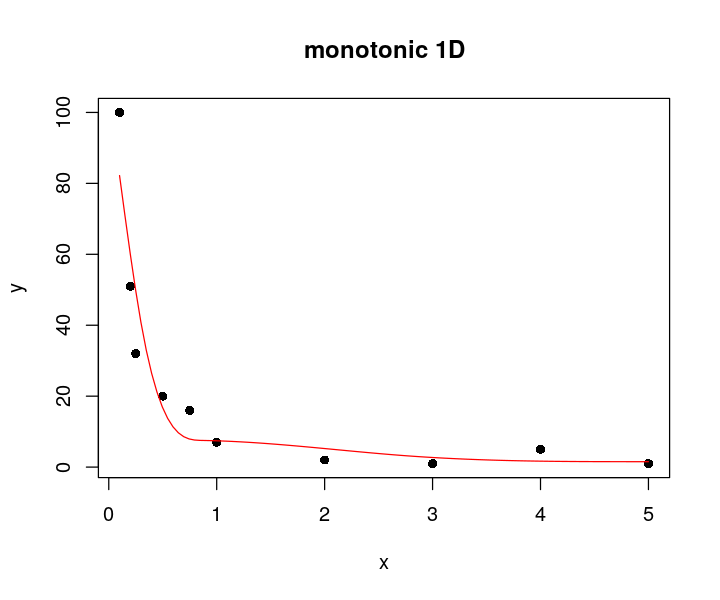

In [29]:
# plot the results
options(repr.plot.width=6, repr.plot.height=5)
plot(y ~ x, data = df, pch = 16, main = 'monotonic 1D')
lines(yhat ~ x, data = newx, col = "red")